# Language modeling

[Google Colab](https://colab.research.google.com/drive/1ICPbTzePq909EN2tHYPahRxo9Dh7r06T?usp=sharing)

Материалы основаны на курсе [Глубинное обучение для текстов](https://artemova.notion.site/artemova/c88a68750cff4b509699fa127be11801)

В этом семинаре мы напишем модель, которая генерирует названия динозавров. Рассмотрим н-граммную статистическую модель и реккурентные сети. Сначала скачаем данные с названиями динозавров

In [1]:
!wget https://raw.githubusercontent.com/artemovae/NLP-seminar-LM/master/dinos.txt

--2023-09-26 18:02:46--  https://raw.githubusercontent.com/artemovae/NLP-seminar-LM/master/dinos.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19909 (19K) [text/plain]
Saving to: ‘dinos.txt’

dinos.txt           100%[===================>]  19.44K  --.-KB/s    in 0.001s  

2023-09-26 18:02:46 (16.4 MB/s) - ‘dinos.txt’ saved [19909/19909]



In [2]:
!cat dinos.txt | tail

Zhuchengtyrannus
Ziapelta
Zigongosaurus
Zizhongosaurus
Zuniceratops
Zunityrannus
Zuolong
Zuoyunlong
Zupaysaurus
Zuul

Предобработаем данные. Один семпл - название динозавра, один токен - символ, символ "<" - начало строки, ">" - конец строки

In [3]:
names = ['<' + name.strip().lower() + '>' for name in open('dinos.txt').readlines()]
print(names[:10])

['<aachenosaurus>', '<aardonyx>', '<abdallahsaurus>', '<abelisaurus>', '<abrictosaurus>', '<abrosaurus>', '<abydosaurus>', '<acanthopholis>', '<achelousaurus>', '<acheroraptor>']


## N-gram language modeling

Bigrams

$$ P(W ) = P(w_{1} , . . . , w_{n} ) ≈ \prod_{i}	 P(w_{i} |w_{i−1} ) $$

Trigrams

$$ P(W ) = P(w_{1} , . . . , w_{n} ) ≈ \prod_{i}	 P(w_{i} |w_{i−1}, w_{i−2} ) $$

Будем использовать библиотеку [NLTK](https://www.nltk.org/)

In [4]:
import nltk

Будем работать на уровне символов. Соберем корпус

In [5]:
chars = [char for name in names for char in name]
print(chars[:20])

['<', 'a', 'a', 'c', 'h', 'e', 'n', 'o', 's', 'a', 'u', 'r', 'u', 's', '>', '<', 'a', 'a', 'r', 'd']


Посчитаем частотности биграм

In [ ]:
for bigram in nltk.bigrams(chars):
    print(bigram)
    break

('<', 'a')


In [6]:
cfreq = nltk.ConditionalFreqDist(nltk.bigrams(chars))

In [ ]:
cfreq['a']

FreqDist({'u': 791, 'n': 347, 't': 204, 's': 171, 'l': 138, '>': 138, 'r': 124, 'c': 100, 'p': 89, 'm': 68, ...})

In [ ]:
cfreq['a'].most_common(1)[0][0]

'u'

Определим функцию генерации

In [10]:
def generate_dino_name(n):
    name = '<'
    for i in range(n):
        name += cfreq[name[-1]].most_common(1)[0][0]
    name += '>'
    return name

In [11]:
for i in range(10):
    print(generate_dino_name(7))

<aus><au>
<aus><au>
<aus><au>
<aus><au>
<aus><au>
<aus><au>
<aus><au>
<aus><au>
<aus><au>
<aus><au>


Можно лучше?

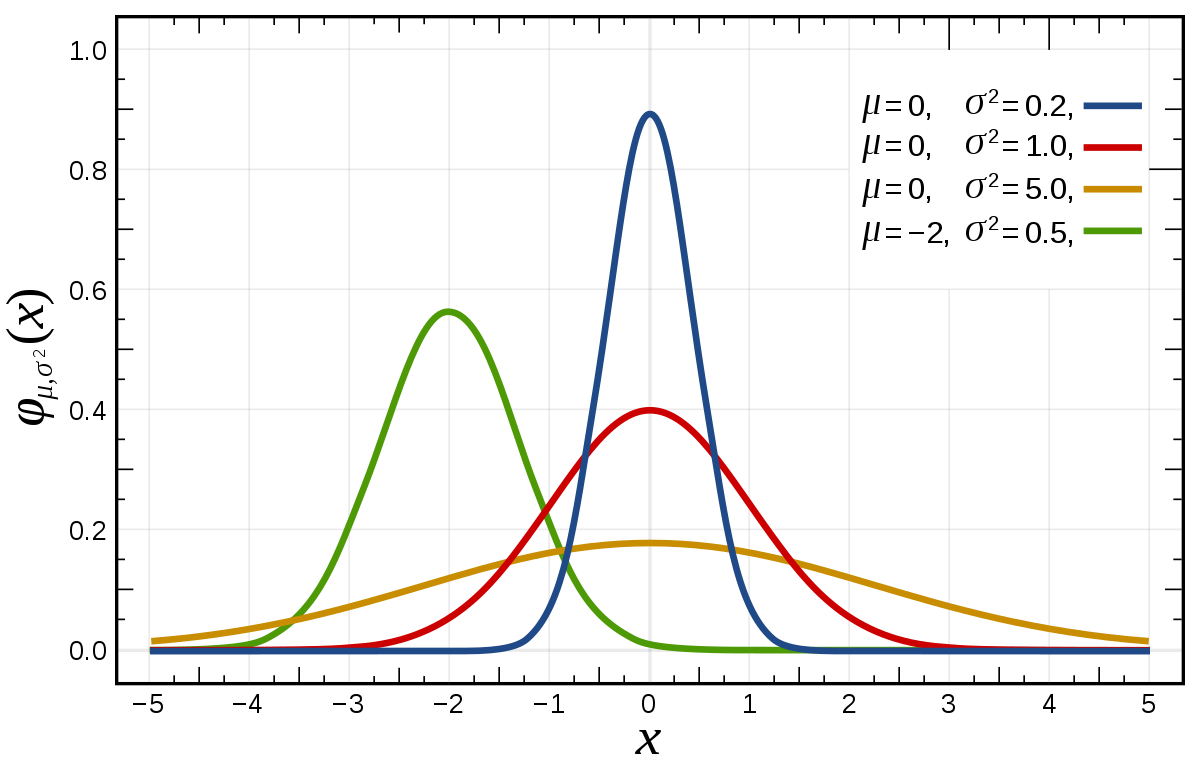

In [12]:
cprob = nltk.ConditionalProbDist(cfreq, nltk.MLEProbDist)

In [15]:
for i in range(10):
    print(cprob["a"].generate())

u
e
t
u
u
u
t
k
c
p


In [16]:
def generate_dino_name(n):
    name = '<'
    for i in range(n):
        name += cprob[name[-1]].generate()
    name += '>'
    return name

In [17]:
for i in range(10):
    print(generate_dino_name(7))

<rachopn>
<lidruru>
<phicola>
<nyoca><>
<dimps><>
<dros><h>
<s><ps><>
<kstauro>
<angopha>
<loratra>


#### **Задание.**
Измените функцию генерации так, чтобы можно было генерировать названия разной длины (модель предсказывает следующий символ до тех пор, пока не будет сгенерирован символ конца строки).

### Домашнее задание №1

Проделать все то же для триграм

In [ ]:
trigrams = nltk.trigrams(chars)
condition_pairs = # your code here to get pairs of ((w0, w1), w2) instead of (w0, w1, w2)
cfreq = nltk.ConditionalFreqDist(condition_pairs)

## Рекуррентные сети

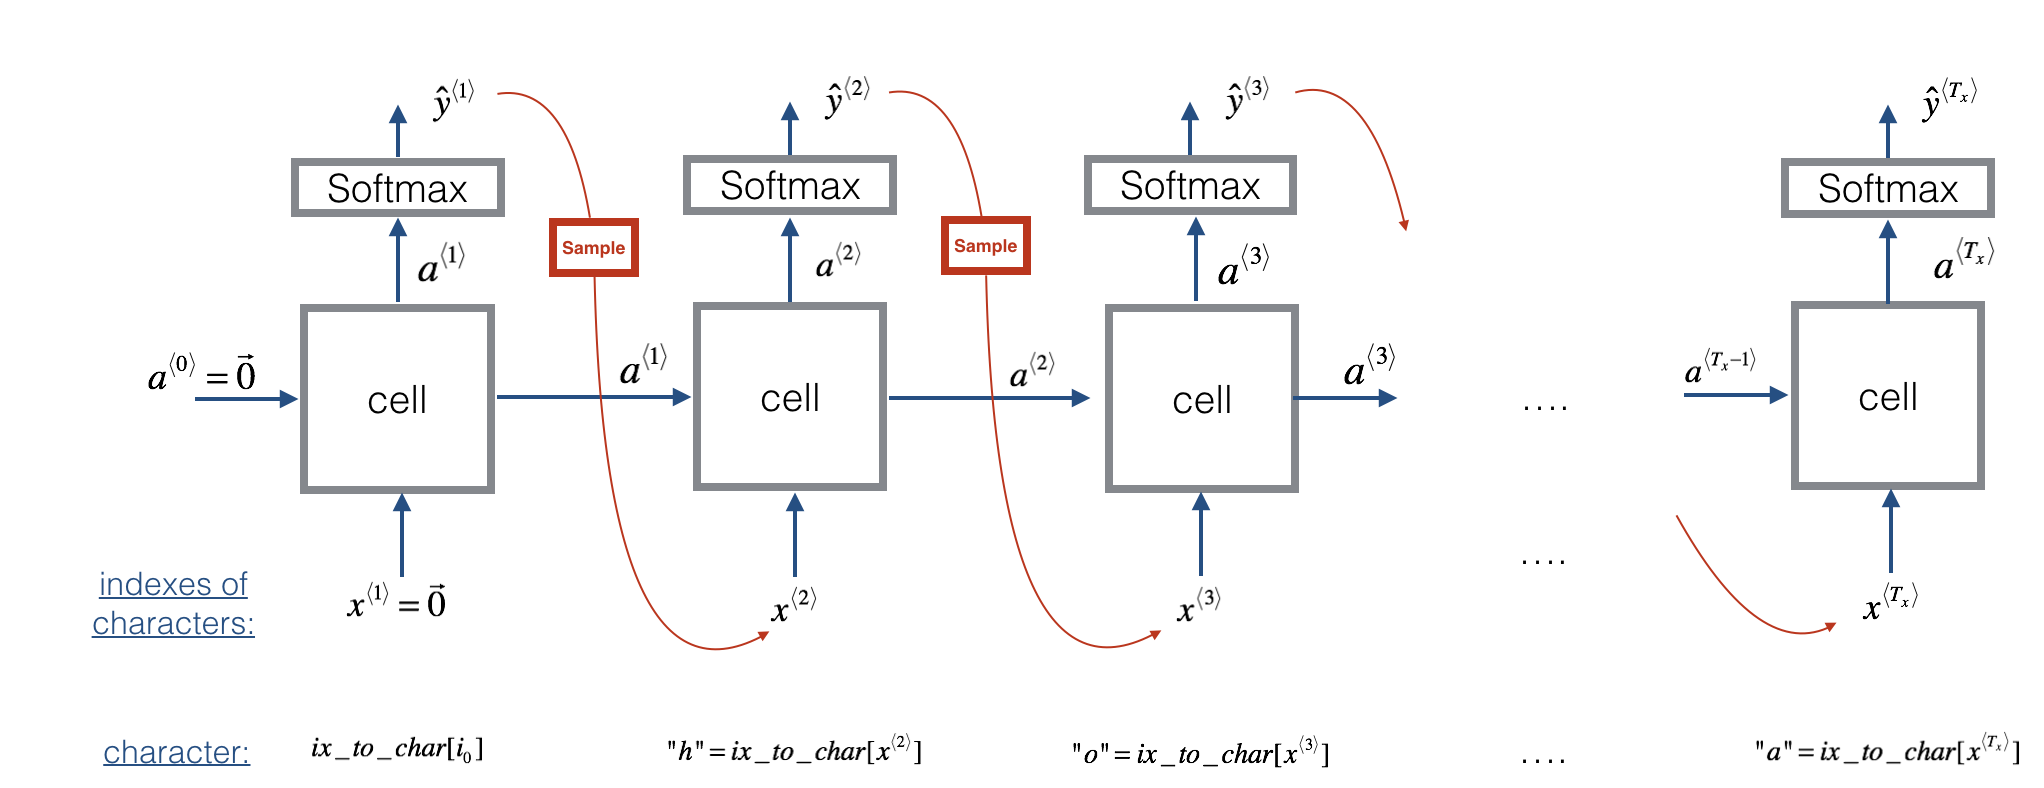

In [18]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import pdb
from torch.utils.data import Dataset, DataLoader

%load_ext autoreload
%autoreload 2

torch.set_printoptions(linewidth=200)

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
hidden_size = 50

Определим датасет и даталодер. Допишите в функции `__getitem__()` преобразование `x` в one-hot-encoding, а `y` - в вектор индексов символов.

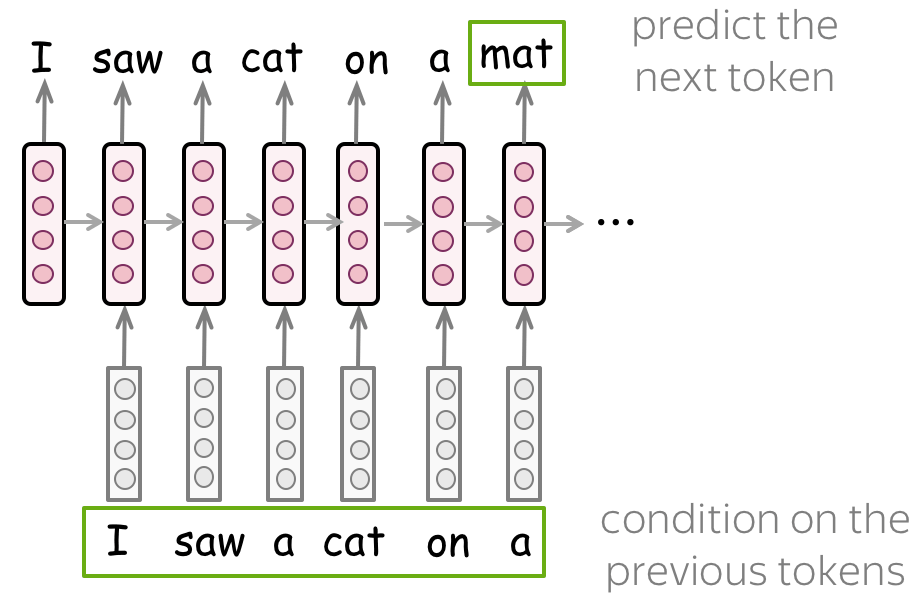

In [ ]:
class DinosDataset(Dataset):
    def __init__(self):
        super().__init__()
        with open('dinos.txt') as f:
            content = f.read().lower()
            self.vocab = sorted(set(content)) + ['<', '>']
            self.vocab_size = len(self.vocab)
            self.lines = content.splitlines()
        self.ch_to_idx = {c:i for i, c in enumerate(self.vocab)}
        self.idx_to_ch = {i:c for i, c in enumerate(self.vocab)}

    def __getitem__(self, index):
        line = self.lines[index]
        x_str = '<' + line
        y_str = line + '>'

        x = torch.zeros([_, _], dtype=torch.float)
        y = torch.empty(_, dtype=torch.long)
        for i, (x_ch, y_ch) in enumerate(zip(x_str, y_str)):
            # your code here

        return x, y

    def __len__(self):
        return len(self.lines)

In [ ]:
trn_ds = DinosDataset()
trn_dl = DataLoader(trn_ds, shuffle=True)

Напишем модель RNN, определим функцию потерь и отпимизатор

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.dropout = nn.Dropout(0.3)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, h_prev, x):
        combined = torch.cat([h_prev, x], dim = 1)
        h = torch.tanh(self.dropout(self.i2h(combined)))
        y = self.h2o(h)
        return h, y

In [ ]:
model = RNN(trn_ds.vocab_size, hidden_size, trn_ds.vocab_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

Напишем функцию семплирования. Допишите код для получения индекса предсказанного символа

In [ ]:
def sample(model):
    model.eval()
    word_size=0
    newline_idx = trn_ds.ch_to_idx['>']
    with torch.no_grad():
        h_prev = torch.zeros([1, hidden_size], dtype=torch.float, device=device)
        x = h_prev.new_zeros([1, trn_ds.vocab_size])
        start_char_idx = trn_ds.ch_to_idx['<']
        predicted_name = ['<']
        x[0, start_char_idx] = 1
        predicted_char_idx = start_char_idx

        while predicted_char_idx != newline_idx and word_size != 50:
            # your code here: output = model(input)

            idx = # your code here

            predicted_name.append(trn_ds.idx_to_ch[idx])

            x = x.new_zeros([1, trn_ds.vocab_size])
            x[0, idx] = 1

            predicted_char_idx = idx

            word_size += 1

        if word_size == 50:
            predicted_name.append(">")

    return "".join(predicted_name)

Напишем цикл обучения

In [ ]:
def train_one_epoch(model, loss_fn, optimizer):
    for line_num, (x, y) in enumerate(trn_dl):
        model.train()

        loss = 0
        optimizer.zero_grad()
        h_prev = torch.zeros([1, hidden_size], dtype=torch.float, device=device)
        x, y = x.to(device), y.to(device)

        for i in range(x.shape[1]):
            h_prev, y_pred = model(h_prev, x[:, i])
            loss += loss_fn(y_pred, y[:, i])

        if (line_num+1) % 100 == 0:
            print(sample(model))
        loss.backward()
        optimizer.step()

In [ ]:
def train(model, loss_fn, optimizer, dataset='dinos', epochs=1):
    for e in range(1, epochs+1):
        print('Epoch:{}'.format(e))
        train_one_epoch(model, loss_fn, optimizer)
        print()

In [ ]:
train(model, loss_fn, optimizer, epochs = 10)

#### **Задание.**
Измените функцию семплирования так, чтобы следующий символ выбирался не как наиболее вероятный, а из распределения вероятностей.

### Домашнее задание №2*

Реализовать LSTM. Для этого надо дописать недостающий код в классе с моделью, немного поменять функции семплинга и обучения.

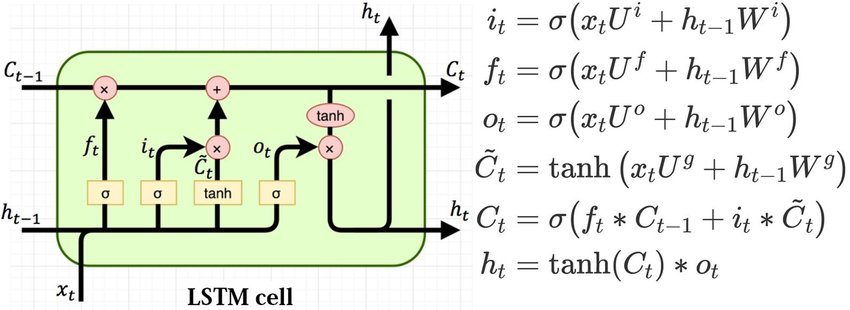

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.weight_ih = torch.nn.Parameter(torch.randn(4 * hidden_size, input_size))
        self.weight_hh = torch.nn.Parameter(torch.randn(4 * hidden_size, hidden_size))
        self.bias_ih = torch.nn.Parameter(torch.randn(4 * hidden_size))
        self.bias_hh = torch.nn.Parameter(torch.randn(4 * hidden_size))
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, input, state):
        hx, cx = state
        gates = (torch.mm(input, self.weight_ih.t()) + self.bias_ih +
                 torch.mm(hx, self.weight_hh.t()) + self.bias_hh)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        ingate = torch.sigmoid(ingate)
        forgetgate = # your code here
        cellgate = # your code here
        outgate = # your code here

        cy = # your code here
        hy = # your code here

        y = self.h2o(hy)

        return hy, cy, y

In [ ]:
model = LSTM(10, 5, 10)

h_prev = torch.zeros([1, 5], dtype=torch.float)
c_prev = torch.zeros([1, 5], dtype=torch.float)
x = h_prev.new_zeros([1, 10])
x[0, 0] = 1

h, c, y_pred = model(x, (h_prev, c_prev))

assert (h_prev.shape, c_prev.shape, x.shape) == (h.shape, c.shape, y_pred.shape)

In [ ]:
model = # your code here
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

In [ ]:
def sample(model):
    model.eval()
    word_size=0
    newline_idx = trn_ds.ch_to_idx['>']
    with torch.no_grad():
        h_prev =  # your code here
        c_prev =  # your code here
        x = h_prev.new_zeros([1, trn_ds.vocab_size])
        start_char_idx = trn_ds.ch_to_idx['<']
        predicted_name = ['<']
        x[0, start_char_idx] = 1
        predicted_char_idx = start_char_idx

        while predicted_char_idx != newline_idx and word_size != 50:
            # your code here: output = model(input)

            y_softmax_scores = torch.softmax(y_pred, dim=1)
            np.random.seed(np.random.randint(1, 5000))
            idx = np.random.choice(np.arange(trn_ds.vocab_size), p=y_softmax_scores.cpu().numpy().ravel())

            predicted_name.append(trn_ds.idx_to_ch[idx])

            x = x.new_zeros([1, trn_ds.vocab_size])
            x[0, idx] = 1

            predicted_char_idx = idx

            word_size += 1

        if word_size == 50:
            predicted_name.append(">")

    return "".join(predicted_name)

In [ ]:
def train_one_epoch(model, loss_fn, optimizer):
    for line_num, (x, y) in enumerate(trn_dl):
        model.train()
        loss = 0
        optimizer.zero_grad()
        h_prev = # your code here
        c_prev = # your code here
        x, y = x.to(device), y.to(device)

        for i in range(x.shape[1]):
            # your code here: output = model(input)
            loss += loss_fn(y_pred, y[:, i])

        if (line_num+1) % 100 == 0:
            print(sample(model))
        loss.backward()
        optimizer.step()

In [ ]:
train(model, loss_fn, optimizer, epochs = 10)